# 对 HuggingFace 公开大模型的数据分析

最受用户喜欢的文本生成模型是怎样的？

# 数据爬取

Hugging Face 仅提供 100 页（每页30个模型）的数据供浏览，也即 3000 个模型，但存放的数据远比这个多（截至2024.12.15有 1,201,412 个模型）。

因此爬取全站的模型是不可行的，哪怕将范围拉到最近7天内的文本生成模型，就有超过 3000 个模型。因此，我们的爬取策略转换为

- 爬取前 3000 个最受用户喜欢的文本生成模型

对其进行数据分析。

In [1]:
import requests
import json
import os
from typing import List
# this url was reverse engineered
base_url = "https://huggingface.co/models-json"

def get_single_page_models(p) -> List[dict]:
    '''30 models per page'''
    assert 0 <= p <= 99, 'page must be positive and less than or equal to 99'
    models = []
    cache_path = f'cache/models_page_{p}.json'
    # read from cache if exists
    if os.path.exists(cache_path):
        with open(cache_path, 'r') as f:
            models = json.load(f)
    else:
        resp = requests.get(base_url, params={"p": p,
                                              "sort": "likes",
                                              "pipeline_tag": "text-generation",
                                              "withCount": True    # default true
                                              })
        models = resp.json().get('models', [])
        
        if not os.path.exists('cache'):
            os.makedirs('cache')
        
        with open(cache_path, 'w') as f:
            json.dump(models, f)
    
    return models

# example of model data
get_single_page_models(1)[0]

{'author': '01-ai',
 'authorData': {'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/6536187279f1de44b5e02d0f/-T8Xw0mX67_R73b7Re1y-.png',
  'fullname': '01-ai',
  'name': '01-ai',
  'type': 'org',
  'isHf': False,
  'isMod': False,
  'isEnterprise': False,
  'followerCount': 570},
 'downloads': 4572,
 'gated': False,
 'id': '01-ai/Yi-34B',
 'inference': 'not-popular-enough',
 'lastModified': '2024-11-11T03:31:31.000Z',
 'likes': 1287,
 'pipeline_tag': 'text-generation',
 'private': False,
 'repoType': 'model',
 'isLikedByUser': False,
 'widgetOutputUrls': []}

## 二级爬取

模型参数作为标签不出现在概览中，针对模型大小的分析，我们考虑通过正则表达式来获取模型大小，例如

`meta-llama/Llama-3.3-70B-Instruct` 就可以pattern匹配得到模型大小为70B。

问题: 如果模型名不包含参数大小, 方法失效.

此外, 有一些模型的参数比较特殊, 例如 `mistralai/Mixtral-8x7B-Instruct-v0.1` 提取出来是 8x7B? 7B? 但实际上是 46.7B.

于是我们认为有需要进入详细页面爬取具体的模型参数.

![model size](images/model_size.png)

In [2]:
from lxml import html
import re

def get_model_para(model: str, cached=True):
    '''given a model name, return the model size in billion.
    >>> print(get_model_para('CohereForAI/c4ai-command-r7b-12-2024'))
    8.03
    '''
    author, model_name = model.split('/')
    cache_path = f'cache/{author}-{model_name}.html'
    
    if os.path.exists(cache_path) and cached:
        with open(cache_path, 'r') as f:
            raw_html = f.read()
    else:
        base_url = 'https://huggingface.co/'
        resp = requests.get(base_url + model)
        raw_html = resp.content.decode('utf-8')
        
        if cached:
            with open(cache_path, 'w') as f:
                f.write(raw_html)
    
    tree = html.fromstring(raw_html)
    try:
        para = tree.xpath('//div[@class="px-1.5"]')[0]
        model_size = re.findall(r'(\d+\.\d+)B params', para.text)[0]
        model_size = round(float(model_size))
    except:
        # no model size found at tag
        model_size = None
    return model_size


# example usage
print(get_model_para('CohereForAI/c4ai-command-r7b-12-2024'))

8


## Sqlite ORM

定义数据模型，将数据模型映射到数据库表中，数据存储在本地数据库 SQlite 中

In [3]:
import datetime

from sqlalchemy import Integer, String, DateTime, ForeignKey
from sqlalchemy.orm import DeclarativeBase
from sqlalchemy.orm import Mapped, mapped_column, relationship

class Base(DeclarativeBase):
    pass


class Author(Base):
    __tablename__ = 'Author'
    
    id: Mapped[int] = mapped_column(primary_key=True)
    name: Mapped[str] = mapped_column(String(40), unique=True)
    type: Mapped[str] = mapped_column(String(40))
    isEnterprise: Mapped[bool] = mapped_column(Integer)
    
    models: Mapped[List["Model"]] = relationship(
        "Model", back_populates="author", cascade="all, delete-orphan"
    )
    
    def __repr__(self):
        return f"<{self.name}>"
    
    def to_dict(self):
        return {
            "id": self.id,
            "name": self.name,
            "type": self.type,
            "isEnterprise": self.isEnterprise,
        }


class Model(Base):
    __tablename__ = 'Model'
    
    id: Mapped[int] = mapped_column(primary_key=True)
    name: Mapped[str] = mapped_column(String(40), unique=True)
    lastModified: Mapped[datetime.datetime] = mapped_column(DateTime)
    downloads: Mapped[int] = mapped_column(Integer)
    likes: Mapped[int] = mapped_column(Integer)
    
    author_id: Mapped[int] = mapped_column(Integer, ForeignKey('Author.id'))
    author: Mapped[Author] = relationship("Author", back_populates="models")
    
    def __repr__(self):
        return f"<{self.name}>"
    
    def to_dict(self):
        return {
            "id": self.id,
            "name": self.name,
            "lastModified": self.lastModified,
            "downloads": self.downloads,
            "likes": self.likes,
            "author_id": self.author_id,
        }

模型序列化器：给一个 dict，返回一个对象

In [4]:
def author_seralizer(author_data) -> Author:
    # print(author_data)
    author = Author(
        name=author_data['name'],
        type=author_data['type'],
        isEnterprise=author_data.get('isEnterprise', False),
    )
    return author

def model_serializer(model_data) -> Model:
    model = Model(
        name=model_data['id'],
        lastModified=datetime.datetime.strptime(model_data['lastModified'], '%Y-%m-%dT%H:%M:%S.%fZ'),
        downloads=model_data['downloads'],
        likes=model_data['likes'],
        author=author_seralizer(model_data['authorData']),
    )
    return model

## 数据库操纵

### 创建数据库

In [5]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///data.db', echo=False)
# If no migration
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)

### 爬取与存放数据

In [6]:
from sqlalchemy.orm import Session

mx_page = 99
with Session(engine) as session:
    for page in range(0, mx_page + 1):
        models = get_single_page_models(page)
        for model in models:
            model_obj = model_serializer(model)
            # 如果作者已存在，则使用已存在的作者对象，否则重复创建会导致唯一约束冲突
            existing_author = session.query(Author).filter_by(name=model_obj.author.name).first()
            if existing_author:
                model_obj.author = existing_author
            session.add(model_obj)
        
    session.commit()

## 转换为 Dataframe

In [7]:
import pandas as pd

models = pd.read_sql_table('Model', 'sqlite:///data.db')
models.head()

,id,name,lastModified,downloads,likes,author_id
0,1,meta-llama/Meta-Llama-3-8B,2024-09-27 15:52:33,658207,5914,1
1,2,bigscience/bloom,2023-07-28 17:50:20,14597,4794,2
2,3,mistralai/Mixtral-8x7B-Instruct-v0.1,2024-08-19 13:18:42,1290346,4226,3
3,4,meta-llama/Llama-2-7b,2024-04-17 08:12:44,0,4187,1
4,5,meta-llama/Llama-2-7b-chat-hf,2024-04-17 08:40:48,1048193,4066,1


In [8]:
authors = pd.read_sql_table('Author', 'sqlite:///data.db')
authors.head()

,id,name,type,isEnterprise
0,1,meta-llama,org,1
1,2,bigscience,org,0
2,3,mistralai,org,1
3,4,microsoft,org,0
4,5,google,org,0


In [9]:
models.describe()

,id,lastModified,downloads,likes,author_id
count,3000.000000,3000,3.000000e+03,3000.000000,3000.000000
mean,1500.500000,2024-02-22 14:44:39.612333312,5.431510e+04,119.225667,200.764333
min,1.000000,2021-03-03 01:44:59,0.000000e+00,19.000000,1.000000
25%,750.750000,2023-09-29 20:49:27.750000128,2.377500e+02,27.000000,25.000000
50%,1500.500000,2024-03-14 18:41:07,1.344500e+03,43.000000,119.000000
75%,2250.250000,2024-07-29 06:11:10.750000128,5.713750e+03,92.000000,310.250000
max,3000.000000,2024-12-15 01:55:41,1.839596e+07,5914.000000,787.000000
std,866.169729,NaN,5.414750e+05,310.252950,207.117189


In [10]:
authors.describe()

,id,isEnterprise
count,787.000000,787.000000
mean,394.000000,0.049555
std,227.331623,0.217162
min,1.000000,0.000000
25%,197.500000,0.000000
50%,394.000000,0.000000
75%,590.500000,0.000000
max,787.000000,1.000000


# 数据预处理

## 模型参数

##### 探索regex的可行性？

In [11]:
def extract_model_size(model_name):
    pattern = r'(\d+(?:x\d+)?[Bb])'
    match = re.search(pattern, model_name)
    return match.group(1) if match else None

In [12]:
models.loc[:, 'model_size'] = models['name'].apply(
    extract_model_size)
models.head()

,id,name,lastModified,downloads,likes,author_id,model_size
0,1,meta-llama/Meta-Llama-3-8B,2024-09-27 15:52:33,658207,5914,1,8B
1,2,bigscience/bloom,2023-07-28 17:50:20,14597,4794,2,None
2,3,mistralai/Mixtral-8x7B-Instruct-v0.1,2024-08-19 13:18:42,1290346,4226,3,8x7B
3,4,meta-llama/Llama-2-7b,2024-04-17 08:12:44,0,4187,1,7b
4,5,meta-llama/Llama-2-7b-chat-hf,2024-04-17 08:40:48,1048193,4066,1,7b


In [13]:
models.isna().sum()

id                0
name              0
lastModified      0
downloads         0
likes             0
author_id         0
model_size      562
dtype: int64

In [14]:
def to_int(model_size):
    pattern = r'(\d+)[Bb]'
    if model_size:
        if type(model_size) == int:
            return model_size
        match = re.search(pattern, model_size)
        if match:
            return int(match.group(1))
        else:
            return None
    return None


print(to_int('0x128b'))
print(to_int(127))
print(to_int(None))

128
127
None


In [15]:
models.loc[:, 'model_size'] = models['model_size'].apply(to_int)

## 缺省值处理

In [16]:
models['model_size'] = models.apply(lambda row: get_model_para(
    row['name']) if pd.isna(row['model_size']) else row['model_size'], axis=1)
models.dropna(inplace=True)

In [17]:
models.to_csv('models.csv', index=False)

## 数据集分割

In [123]:
models = pd.read_csv('models.csv')

In [125]:
def split_qualified_models(models: pd.DataFrame, likes_threshold, download_threshold):
    criteria = (models['downloads'] < download_threshold) | (
        models['likes'] < likes_threshold)

    low_quality_models = models[criteria]
    high_quality_models = models[~criteria]

    return high_quality_models, low_quality_models


def split_models_by_time(models: pd.DataFrame, time_threshold):
    criteria = models['lastModified'] > time_threshold

    recent_models = models[criteria]
    old_models = models[~criteria]

    return recent_models, old_models

In [127]:
likes_threshold = models.describe().loc['25%', 'likes']
download_threshold = 10

high_quality_models, low_quality_models = split_qualified_models(
    models, likes_threshold, download_threshold)
high_quality_models.describe()

,id,downloads,likes,author_id,model_size
count,2252.000000,2.252000e+03,2252.000000,2252.000000,2009.000000
mean,1158.667851,6.953775e+04,147.034192,167.015986,19.845197
std,668.321733,6.230771e+05,341.845723,170.620642,34.121961
min,1.000000,1.000000e+01,27.000000,1.000000,1.000000
25%,582.750000,4.545000e+02,37.000000,25.000000,7.000000
50%,1157.500000,1.576000e+03,59.000000,106.000000,8.000000
75%,1736.250000,8.098750e+03,119.000000,269.000000,14.000000
max,2318.000000,1.839596e+07,5914.000000,645.000000,405.000000


In [129]:
time_threshold = '2024-01-01 00:00:00'  # this year
high_quality_models_24_after, high_quality_models_24_before = split_models_by_time(
    high_quality_models, time_threshold)
high_quality_models_24_after.describe()

,id,downloads,likes,author_id,model_size
count,1441.000000,1.441000e+03,1441.000000,1441.000000,1310.000000
mean,1133.398334,8.941295e+04,167.399028,173.104094,20.662595
std,677.580583,6.905208e+05,391.402235,171.471601,38.269189
min,1.000000,1.200000e+01,27.000000,1.000000,1.000000
25%,532.000000,5.550000e+02,37.000000,26.000000,7.000000
50%,1133.000000,2.824000e+03,60.000000,114.000000,8.000000
75%,1725.000000,1.228000e+04,132.000000,274.000000,15.000000
max,2318.000000,1.839596e+07,5914.000000,645.000000,405.000000


# 数据可视化

## 模型参数量

### 探究2024年开源社区最喜爱的模型参数量

In [448]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
def reset_index_from_one(models):
    models = models.reset_index(drop=True)
    models.index +=1
    return models
def top_features(models, feature, top_n=10):
    top_models = models.nlargest(top_n, feature)
    return top_models
def draw_ondograph(models,feature):
    plt.rcParams['font.sans-serif'] = ['SimHei']  
    plt.rcParams['axes.unicode_minus'] = False  
    models_sorted = models.sort_values(by=feature, ascending=True)
    colors = plt.cm.viridis(np.linspace(0, 1, len(models)))
    plt.figure(figsize=(12, 8))
    plt.barh(models_sorted['name'],models_sorted['model_size'], color=colors)
    if models is top_downloads_models:
        plt.title('下载量前十的模型')
    if models is top_likes_models:
        plt.title('点赞量前十的模型')
    plt.xlabel('模型参数量(B)')
    plt.ylabel('模型名称')
    plt.xlim(0, 10)
    plt.tight_layout()
    plt.show()

#### 2024年里下载量前十的模型

In [451]:
top_downloads_models = reset_index_from_one(top_features(high_quality_models_24_after, 'downloads', 10))
top_downloads_models

,id,name,lastModified,downloads,likes,author_id,model_size,size_group
1,272,Qwen/Qwen2.5-1.5B-Instruct,2024-09-25 12:32:50,18395955,242,16,5.0,4-7
2,13,openai-community/gpt2,2024-02-19 10:57:45,12315491,2443,7,NaN,NaN
3,454,bartowski/Meta-Llama-3.1-8B-Instruct-GGUF,2024-12-01 04:12:27,9585146,154,114,8.0,7-14
4,8,meta-llama/Llama-3.1-8B-Instruct,2024-09-25 17:00:57,5304098,3260,1,8.0,7-14
5,6,meta-llama/Meta-Llama-3-8B-Instruct,2024-09-27 15:52:39,2458327,3692,1,8.0,7-14
6,46,TinyLlama/TinyLlama-1.1B-Chat-v1.0,2024-03-17 05:07:08,2228703,1100,22,1.0,0-2
7,33,meta-llama/Llama-3.2-1B,2024-10-24 15:08:03,2191380,1258,1,1.0,0-2
8,65,meta-llama/Llama-3.2-3B-Instruct,2024-10-24 15:07:29,2074743,784,1,3.0,2-4
9,90,meta-llama/Llama-3.2-1B-Instruct,2024-10-24 15:07:51,1944765,637,1,1.0,0-2
10,36,mistralai/Mistral-7B-Instruct-v0.3,2024-08-21 12:18:25,1915549,1182,3,7.0,7-14


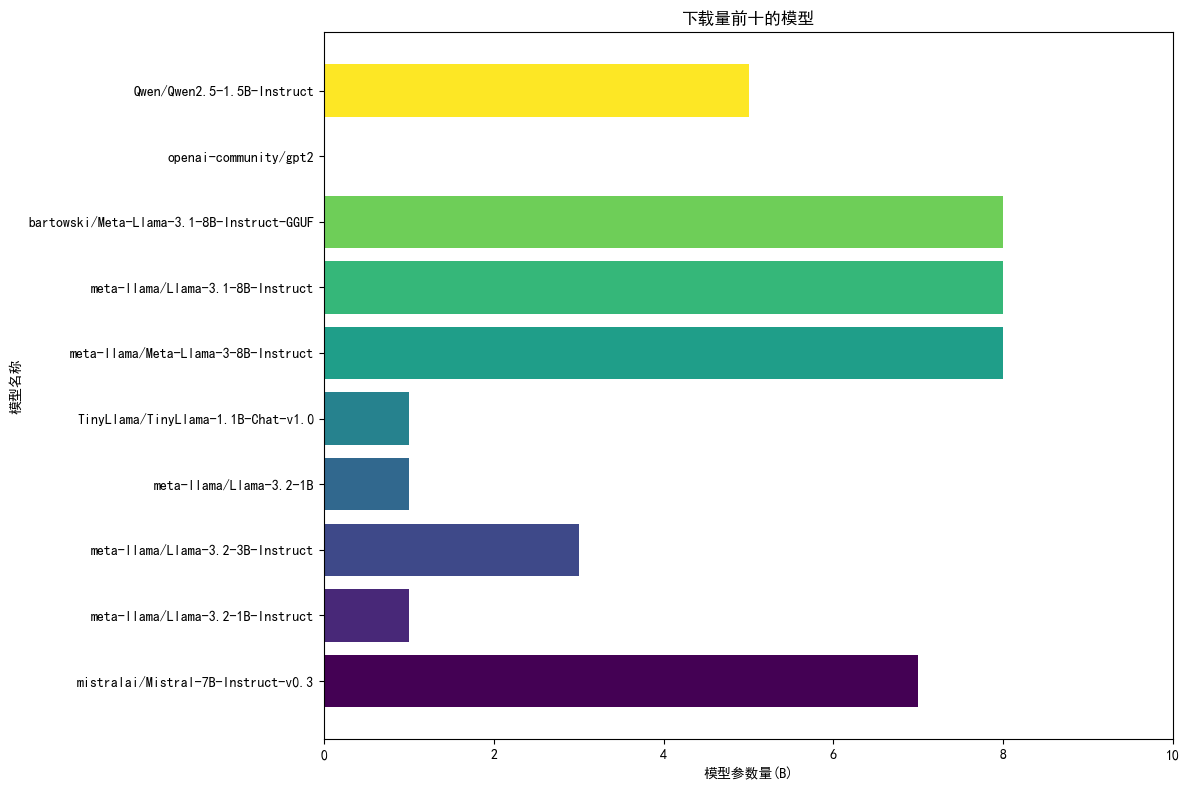

In [453]:
draw_ondograph(top_downloads_models,'downloads')

#### 2024年里点赞量前十的模型

In [456]:
top_likes_models = reset_index_from_one(top_features(high_quality_models_24_after, 'likes', 10))
top_likes_models

,id,name,lastModified,downloads,likes,author_id,model_size,size_group
1,1,meta-llama/Meta-Llama-3-8B,2024-09-27 15:52:33,658207,5914,1,8.0,7-14
2,3,mistralai/Mixtral-8x7B-Instruct-v0.1,2024-08-19 13:18:42,1290346,4226,3,7.0,7-14
3,5,meta-llama/Llama-2-7b-chat-hf,2024-04-17 08:40:48,1048193,4066,1,7.0,7-14
4,6,meta-llama/Meta-Llama-3-8B-Instruct,2024-09-27 15:52:39,2458327,3692,1,8.0,7-14
5,7,mistralai/Mistral-7B-v0.1,2024-07-24 14:04:08,1430813,3489,3,7.0,7-14
6,8,meta-llama/Llama-3.1-8B-Instruct,2024-09-25 17:00:57,5304098,3260,1,8.0,7-14
7,9,microsoft/phi-2,2024-04-29 16:25:56,210517,3252,4,3.0,2-4
8,10,google/gemma-7b,2024-06-27 14:09:40,62326,3075,5,7.0,7-14
9,11,bigcode/starcoder,2024-10-08 20:53:18,16925,2821,6,16.0,14-32
10,12,mistralai/Mistral-7B-Instruct-v0.2,2024-09-27 10:41:20,1692571,2593,3,7.0,7-14


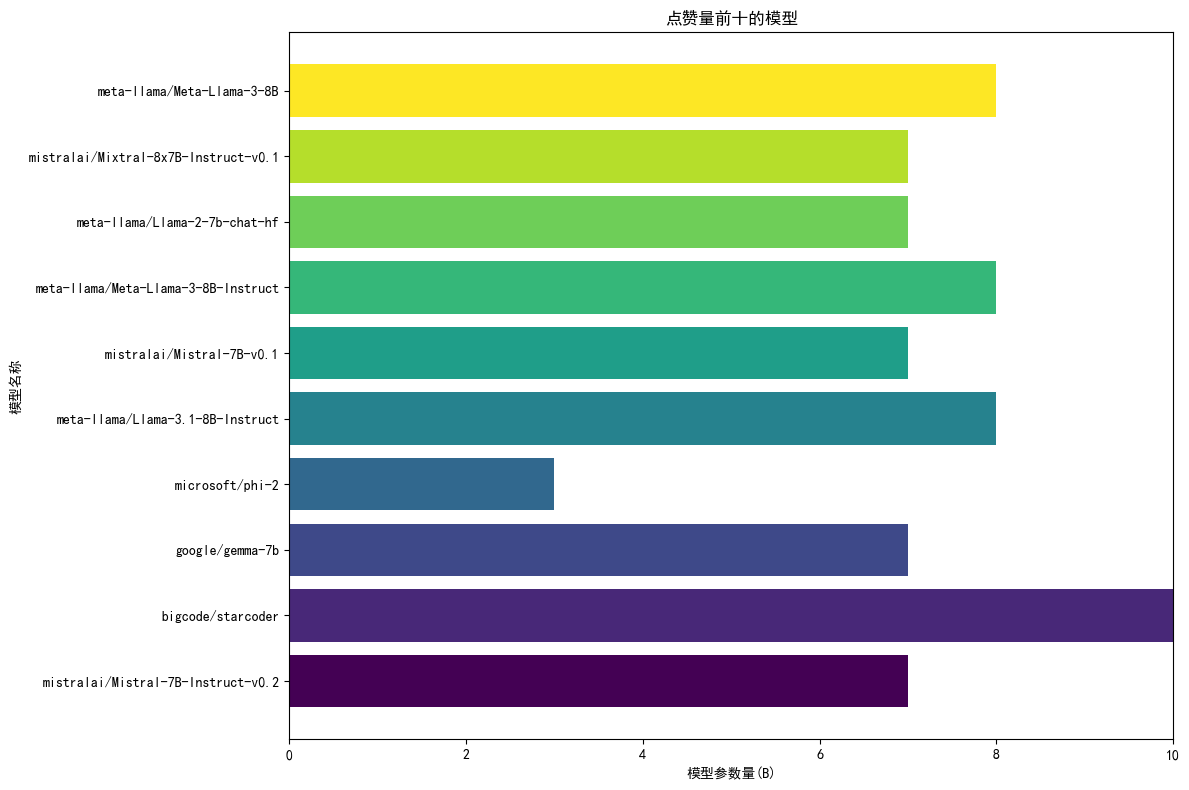

In [458]:
draw_ondograph(top_likes_models,'likes')

#### 2024年里使用数前十的模型参数量

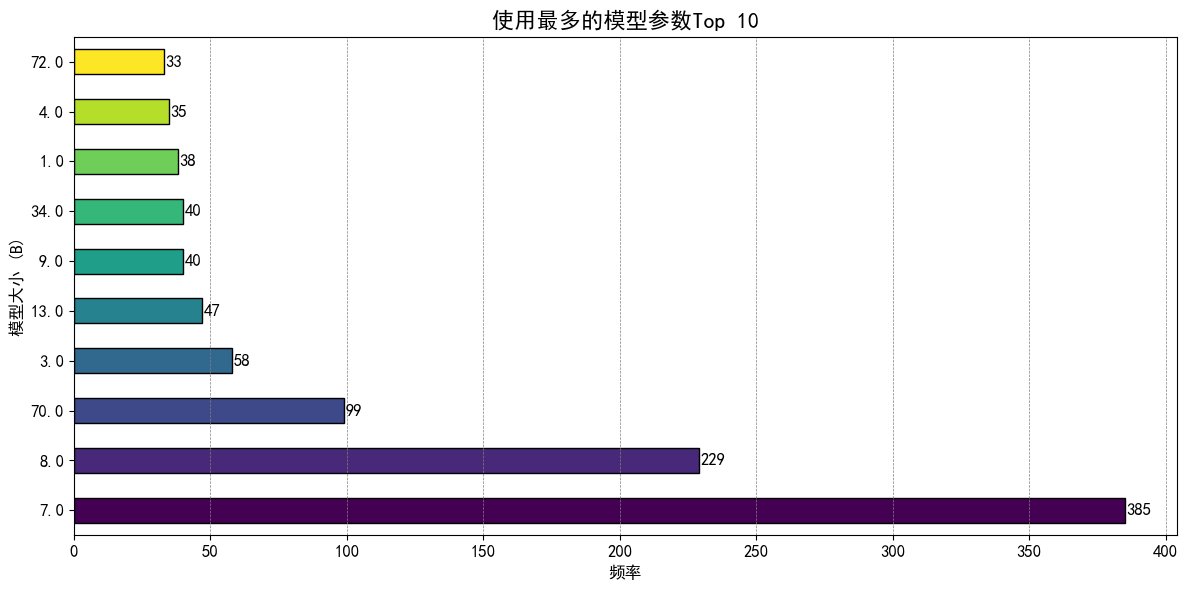

In [431]:
high_quality_models_24_after.loc[:,'model_size'] = high_quality_models_24_after['model_size'].replace('[^0-9.]', '', regex=True).astype(float)
size_counts = high_quality_models_24_after['model_size'].value_counts().head(10)
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, 10))
bars = size_counts.plot(kind='barh', color=colors, edgecolor='black')
for bar in bars.patches:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.0f}',
             va='center', ha='left',
              fontsize=12)
plt.title('使用最多的模型参数Top 10', fontsize=16, fontweight='bold')
plt.xlabel('频率', fontsize=12)
plt.ylabel('模型大小 (B)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', linewidth=0.5, color='gray')
plt.tight_layout()
plt.show()

## 2024年之前所有高质量NLP大模型参数量的分布

In [460]:
def draw_histogram(models):
    #绘制柱状图
    bins = [0, 2, 4, 7, 14, 32, 72, float('inf')]
    labels = ['0-2', '2-4', '4-7', '7-14', '14-32', '32-72', '>72']
    models.loc[:,'size_group'] = pd.cut(models['model_size'].copy(), bins=bins, labels=labels, right=False)
    models_model_counts = models['size_group'].value_counts().sort_index()
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(models_model_counts.index, models_model_counts.values, color='skyblue')
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')
    ax.set_xticks(range(len(model_counts)))
    ax.set_xticklabels(model_counts.index)
    ax.set_xlabel('模型参数量分布(B)')
    ax.set_ylabel('模型数量')
    if models is high_quality_models_24_before:
        ax.set_title('2024年之前高质量大模型参数量分布')
    else:
         ax.set_title('2024年高质量大模型参数量分布')
    plt.tight_layout()
    plt.show()
def draw_pie(models):
    #绘制饼状图
    bins = [0, 2, 4, 7, 14, 32, 72, float('inf')]
    labels = ['0-2', '2-4', '4-7', '7-14', '14-32', '32-72', '>72']
    size_distribution = pd.cut(models['model_size'].copy(), bins=bins, labels=labels, right=False)
    model_counts = size_distribution.value_counts().sort_index()
    plt.figure(figsize=(8, 8))
    colors = ['#FF69B4', '#90EE90', '#FFD700','#FF6347','#FFA07A',  '#00BFFF', '#8A2BE2']
    wedges, texts, autotexts = plt.pie(model_counts, labels=model_counts.index, autopct='%1.1f%%', startangle=140, colors=colors,explode=[0.1 if label == '7-14' else 0 for label in model_counts.index])
    plt.legend(wedges, model_counts.index, title="Shapes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    if models is high_quality_models_24_before:
        plt.title('2024年之前高质量大模型参数量分布')
    if models is high_quality_models_24_after:
        plt.title('2024年高质量大模型参数量分布')
    plt.show()

In [462]:
high_quality_models_24_before.describe()

,id,downloads,likes,author_id,model_size
count,811.000000,8.110000e+02,811.000000,811.000000,699.000000
mean,1203.567201,3.422312e+04,110.849568,156.198520,18.313305
std,649.536101,4.788036e+05,224.398163,168.661554,24.481570
min,2.000000,1.000000e+01,27.000000,2.000000,1.000000
25%,659.500000,1.645000e+02,36.000000,25.000000,7.000000
50%,1201.000000,1.328000e+03,56.000000,77.000000,12.000000
75%,1765.500000,2.825500e+03,106.500000,246.000000,13.000000
max,2281.000000,1.191438e+07,4794.000000,639.000000,180.000000


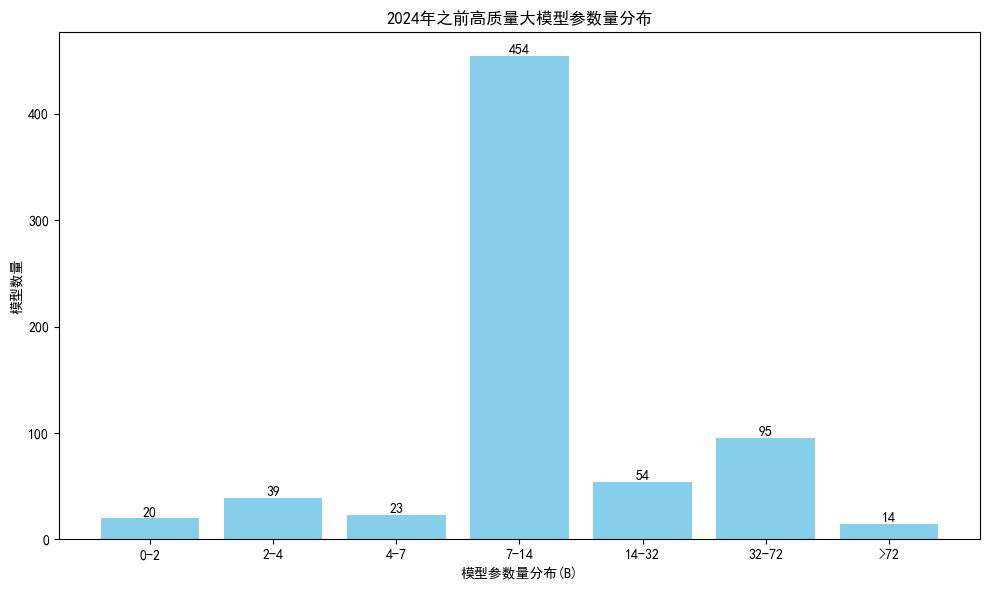

In [464]:
draw_histogram(high_quality_models_24_before)

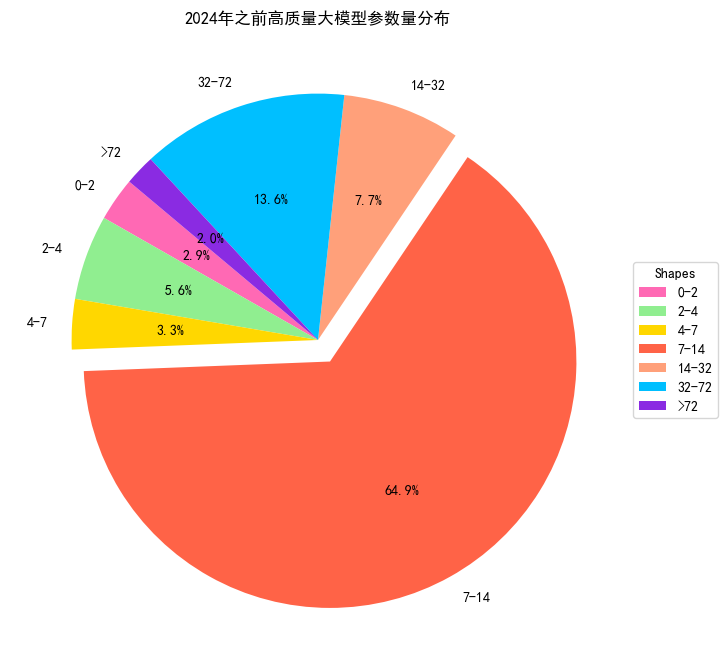

In [466]:
draw_pie(high_quality_models_24_before)

### 2024年之前大模型发展概述：

<style>
  .text-styled {
    font-family: 'Arial', sans-serif;
    line-height: 2; /* 增加行间距 */
    color: #333;
  }
</style>

<div class="text-styled">
  2024年之前，人工智能开始快速发展，特别是在深度学习框架技术能力的提升上。大模型的开发开始盛行，经我们对HuggingFace上大模型任务类型的统计。基本所有的大模型都是文本生成类大模型，这类模型需要处理不同长度和复杂度的文本输入，其性能更大程度上依赖于训练数据的规模和质量，随着2024年之前云计算个高性能计算资源的普及，更多的团队和公司有能力训练大模型，在当时7B—14B是当时大模型的参数量的主流，但是从统计结果中仍然可以得到，小规模数据训练出来的大模型仍旧占有很大一部分比例。
</div>

In [469]:
high_quality_models_24_after.describe()

,id,downloads,likes,author_id,model_size
count,1441.000000,1.441000e+03,1441.000000,1441.000000,1310.000000
mean,1133.398334,8.941295e+04,167.399028,173.104094,20.662595
std,677.580583,6.905208e+05,391.402235,171.471601,38.269189
min,1.000000,1.200000e+01,27.000000,1.000000,1.000000
25%,532.000000,5.550000e+02,37.000000,26.000000,7.000000
50%,1133.000000,2.824000e+03,60.000000,114.000000,8.000000
75%,1725.000000,1.228000e+04,132.000000,274.000000,15.000000
max,2318.000000,1.839596e+07,5914.000000,645.000000,405.000000


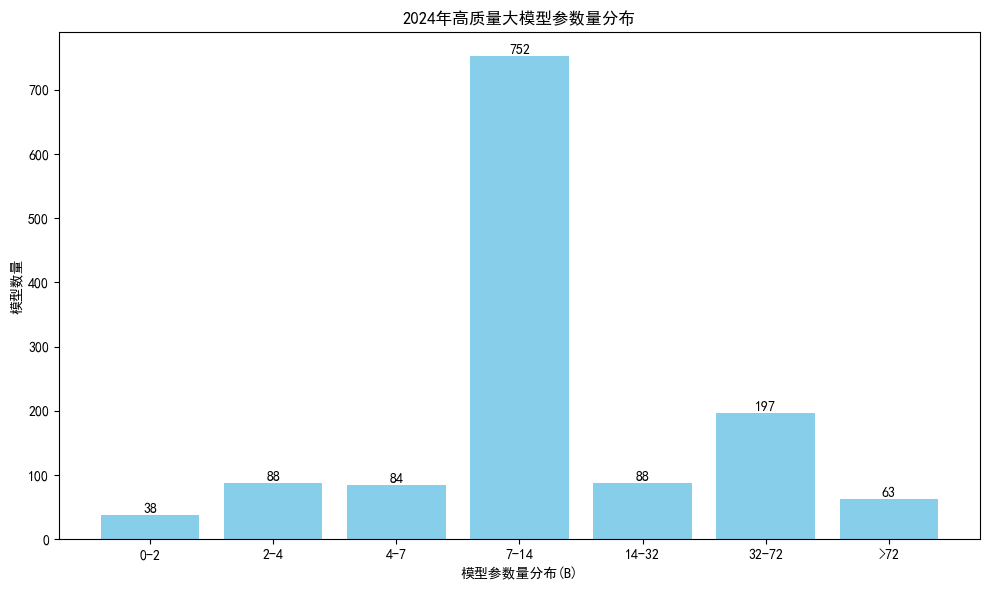

In [471]:
draw_histogram(high_quality_models_24_after)

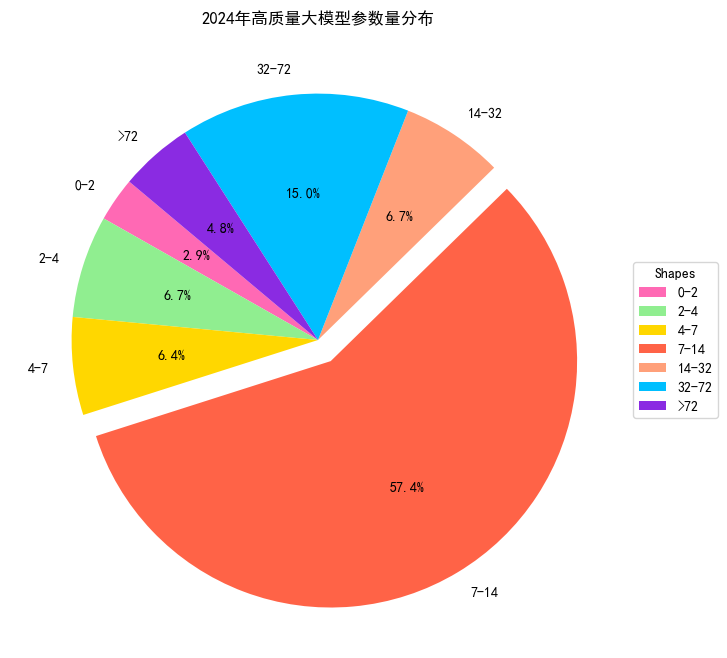

In [473]:
draw_pie(high_quality_models_24_after)

### 2024年大模型的发展：

<style>
  .text-styled {
    font-family: 'Arial', sans-serif;
    line-height: 2; /* 增加行间距 */
    color: #333;
  }
</style>

<div class="text-styled">
  2024年，大模型迎来了蓬勃发展阶段，Openai推出GPT-4o,其强大的逻辑分析能力让人们更加看到了大模型的无限潜力，我们对huggingface上2024年更新的大模型进行分析，虽然参数量仍旧以7B-14B的模型为主，但是可以发现，2024年一年大模型发布的数量甚至超出前几年大模型发布数量总和的好几倍，并且小规模数据训练的模型占比远小于前些年的占比，由此可见，大模型确实是需要更丰富的训练数据，但这并不是绝对的，在我们分析过程中发现，有些用大参数量训练出的大模型受人喜欢程度其实是不如一些小规模数据训练出的大模型的，所有训练一个大模型不仅仅需要大的数据规模还需要一些巧妙的训练方式
</div>

## 时间序列分析

In [477]:
models.head()

,id,name,lastModified,downloads,likes,author_id,model_size,year,month
0,1,meta-llama/Meta-Llama-3-8B,2024-09-27 15:52:33,658207,5914,1,8.0,2024,9
1,2,bigscience/bloom,2023-07-28 17:50:20,14597,4794,2,NaN,2023,7
2,3,mistralai/Mixtral-8x7B-Instruct-v0.1,2024-08-19 13:18:42,1290346,4226,3,7.0,2024,8
3,4,meta-llama/Llama-2-7b,2024-04-17 08:12:44,0,4187,1,7.0,2024,4
4,5,meta-llama/Llama-2-7b-chat-hf,2024-04-17 08:40:48,1048193,4066,1,7.0,2024,4


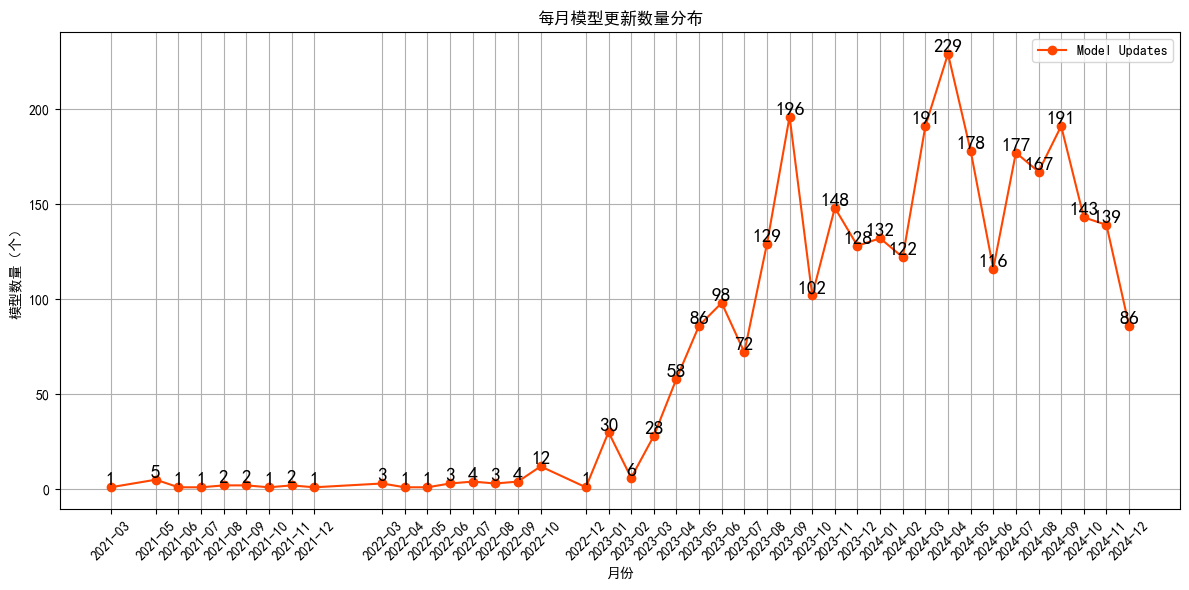

In [479]:
models.loc[:,'lastModified'] = pd.to_datetime(models['lastModified'])
models['lastModified'] = models['lastModified'].apply(lambda x: pd.NaT if pd.isnull(x) else x)
models.loc[:,'year'] = models['lastModified'].copy().dt.year
models.loc[:,'month'] = models['lastModified'].copy().dt.month
monthly_updates = models.groupby(['year', 'month']).size()
monthly_updates = monthly_updates.reset_index(name='count')
# 绘制折线图
plt.figure(figsize=(12, 6)) 
plt.plot(monthly_updates['year'] * 12 + monthly_updates['month'], monthly_updates['count'], marker='o', color='#FF4500', label='Model Updates')
for i, (year, month, count) in enumerate(zip(monthly_updates['year'], monthly_updates['month'], monthly_updates['count'])):
    plt.text(year * 12 + month, count, str(count), color='black', fontsize=14, ha='center', va='bottom')
plt.title('每月模型更新数量分布')
plt.xlabel('月份')
plt.ylabel('模型数量（个）')
plt.grid(True)
plt.xticks(monthly_updates['year'] * 12 + monthly_updates['month'], [f'{y}-{m:02}' for y, m in zip(monthly_updates['year'], monthly_updates['month'])], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## 任务类型分布

## 作者类型